<a href="https://colab.research.google.com/github/noprisigit/ResNet50/blob/main/ResNet50%20Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/iarc-annocerv-master-dataset-split-balanced-augment1500.zip'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/iarc-annocerv-master-dataset-split-balanced-augment1500.zip
   creating: iarc-annocerv-master-dataset-split-balanced-augment1500/
   creating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/
   creating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AAAX4.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AAAZ4.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABA2.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABB2.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABC1.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABD1.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AACG1.jpg  
  

In [3]:
data_dir = '/content/iarc-annocerv-master-dataset-split-balanced-augment1500'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(train_dir))
EPOCHS = 100
LEARNING_RATE = 0.001

print(f'Jumlah Kelas: {NUM_CLASSES}')

Jumlah Kelas: 4


In [4]:
def count_dataset(directory):
  class_counts = {}
  total_count = 0

  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if (os.path.isdir(class_path)):
      num_images = len(os.listdir(class_path))
      class_counts[class_name] = num_images
      total_count += num_images

  return class_counts, total_count

total_images, class_distribution = count_dataset(train_dir)
print(f'Total Images Training: {total_images}')
print('Class Distribution Training:', class_distribution)

total_images, class_distribution = count_dataset(val_dir)
print(f'Total Images Validation: {total_images}')
print('Class Distribution Validation:', class_distribution)

Total Images Training: {'CIN 1': 1104, 'Normal': 770, 'CIN 3': 1104, 'CIN 2': 1104}
Class Distribution Training: 4082
Total Images Validation: {'CIN 1': 44, 'Normal': 26, 'CIN 3': 33, 'CIN 2': 31}
Class Distribution Validation: 134


In [5]:
# === DATA AUGMENTASI (selama training) ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(rescale=1./255)

# === DATASET LOADER ===
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4082 images belonging to 4 classes.
Found 134 images belonging to 4 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Tambahkan custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# Train the model
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
)

end_time = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 174ms/step - accuracy: 0.2694 - loss: 1.5780 - val_accuracy: 0.2463 - val_loss: 1.3751
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.2652 - loss: 1.3830 - val_accuracy: 0.3284 - val_loss: 1.3746
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.2655 - loss: 1.3808 - val_accuracy: 0.2313 - val_loss: 1.3771
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.2921 - loss: 1.3786 - val_accuracy: 0.2463 - val_loss: 1.3797
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.2602 - loss: 1.3778 - val_accuracy: 0.2463 - val_loss: 1.3796
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.2837 - loss: 1.3753 - val_accuracy: 0.2463 - val_loss: 1.3785
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.2704 - loss: 1.3777 - val_accuracy: 0.2313 - val_loss: 1.3783
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.2611 - loss:

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.3359 - loss: 1.3412
Train Accuracy: 0.3395
Train Loss: 1.3368
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5017 - loss: 1.3031
Val Accuracy: 0.3881
Val Loss: 1.3469

Best epoch: 63
Validation Accuracy at Best Epoch: 0.4254

🏁 Training selesai dalam 1281.48 detik
🏆 Best Epoch: 63
✅ Best Train Acc: 0.3021
✅ Best Val Acc: 0.4254
📉 Best Train Loss: 1.3618
📉 Best Val Loss: 1.3539
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 917ms/step
              precision    recall  f1-score   support

      Normal       0.42      0.75      0.54        44
        CIN1       0.23      0.19      0.21        31
        CIN2       0.45      0.39      0.42        33
        CIN3       0.00      0.00      0.00        26

    accuracy                           0.39       134
   macro avg       0.27      0.33      0.29       134
weighted avg       0.30      0.39      0.33       134



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


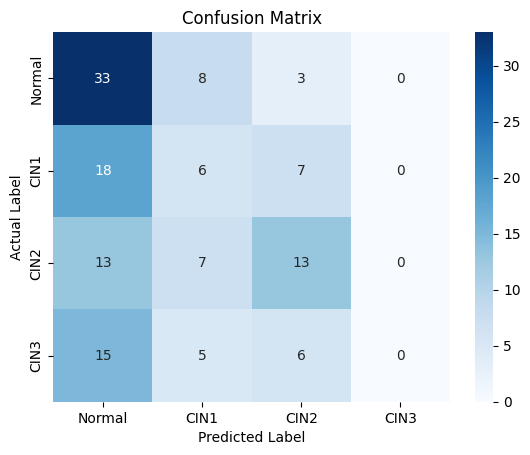

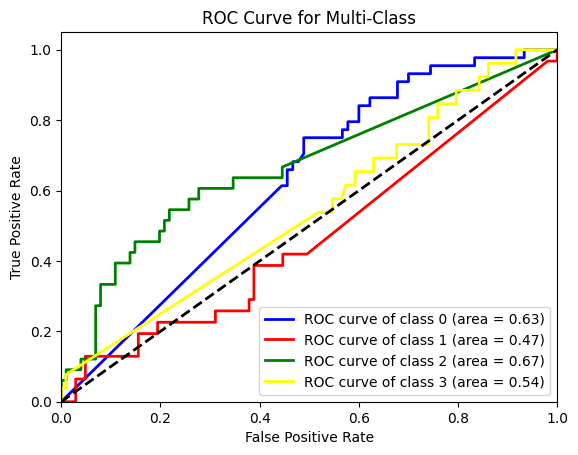

In [8]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(train_generator)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Train Loss: {train_loss:.4f}')

val_loss, val_acc = model.evaluate(val_generator)
print(f'Val Accuracy: {val_acc:.4f}')
print(f'Val Loss: {val_loss:.4f}')

# Misalnya kamu monitor val_accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\nBest epoch: {best_epoch}")
print(f"Validation Accuracy at Best Epoch: {best_val_acc:.4f}")

# === EVALUASI: NILAI TERBAIK ===
training_time = end_time - start_time
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n🏁 Training selesai dalam {training_time:.2f} detik")
print(f"🏆 Best Epoch: {best_epoch+1}")
print(f"✅ Best Train Acc: {history.history['accuracy'][best_epoch]:.4f}")
print(f"✅ Best Val Acc: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"📉 Best Train Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"📉 Best Val Loss: {history.history['val_loss'][best_epoch]:.4f}")

# Predict the test set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'CIN1', 'CIN2', 'CIN3']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'], yticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

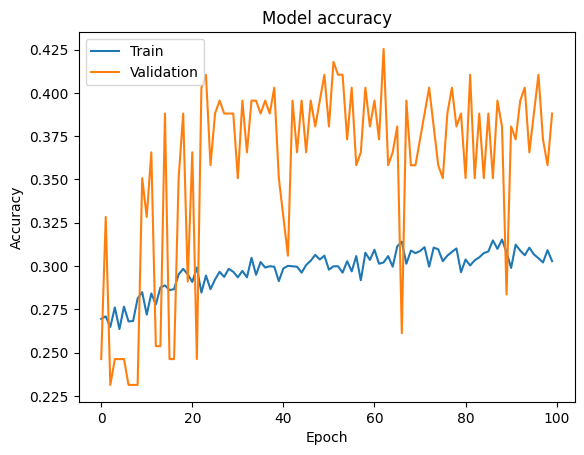

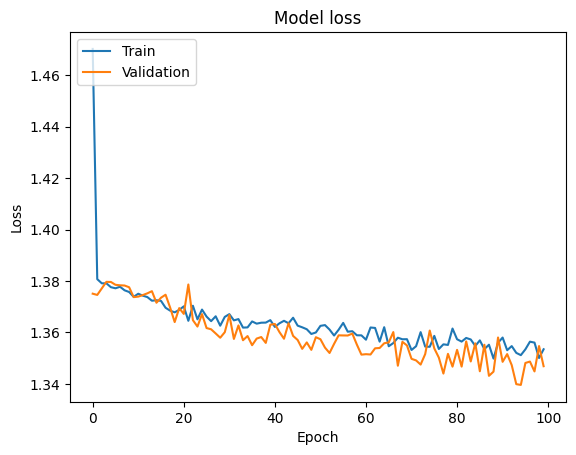

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Calculate sensitivity (recall), precision, and F1-score
sensitivity = recall_score(y_true, y_pred_classes, average=None)
precision = precision_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Calculate specificity
specificity = []
for i in range(3):
    tn = np.sum((y_true != i) & (y_pred_classes != i))
    fp = np.sum((y_true != i) & (y_pred_classes == i))
    specificity.append(tn / (tn + fp))

print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')

Sensitivity: [0.75       0.19354839 0.39393939 0.        ]
Precision: [0.41772152 0.23076923 0.44827586 0.        ]
F1-Score: [0.53658537 0.21052632 0.41935484 0.        ]
Specificity: [np.float64(0.4888888888888889), np.float64(0.8058252427184466), np.float64(0.8415841584158416)]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
